# Handwritten Digit Recognition on MNIST Data using PyTorch 
## Architecture 3: Convolutional Neural Network using Adam optimizer
### Accuracy Obtained: 99.2%

### Necessary imports


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

### Download the Dataset and Define the Transforms

In [ ]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('MNIST_DATASET/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

test_set = datasets.MNIST('MNIST_DATASET/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

### Exploring the Data

In [ ]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([100, 1, 28, 28])
torch.Size([100])


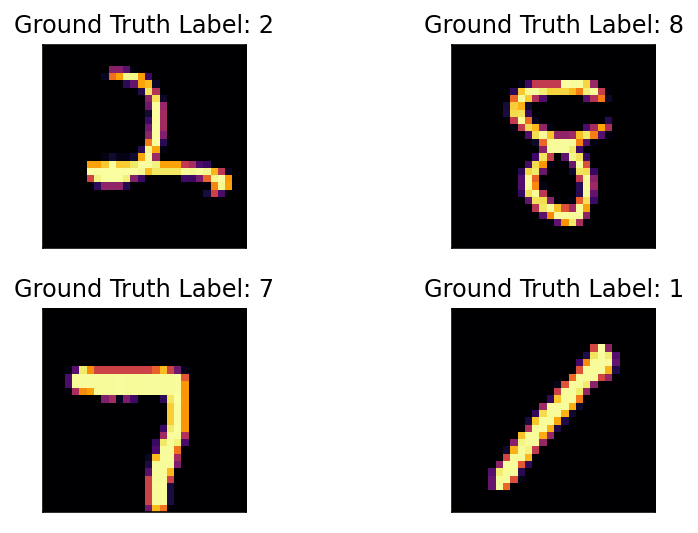

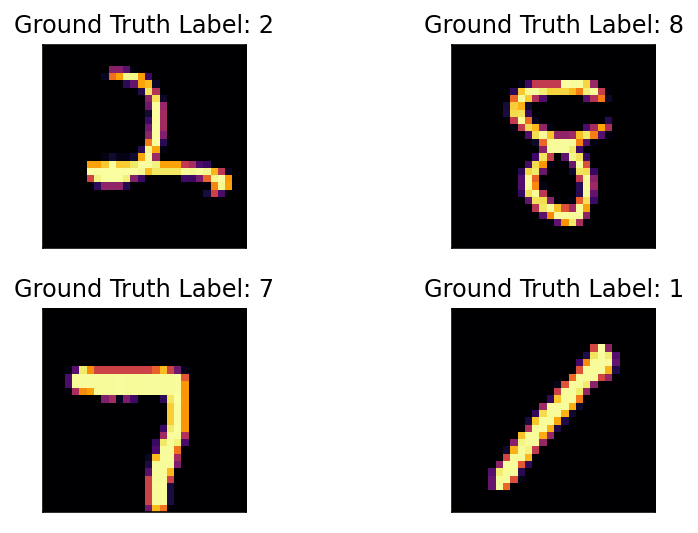

In [ ]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

### Defining the Convolutional Neural Network Architecture


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1) # Conv layer1
      self.conv2 = nn.Conv2d(20, 50, 5, 1) # Conv layer2
      self.fc1 = nn.Linear(4*4*50, 500)    # Fully connected layer1
      self.dropout1 = nn.Dropout(0.5)   # We use dropout layer between these both FCL as they have the highest number of parameters b/t them
      self.fc2 = nn.Linear(500, 10)   # Fully connected layer2
    def forward(self, x):
      x = F.relu(self.conv1(x))  # Apply ReLu to the feature maps produced after Conv 1 layer
      x = F.max_pool2d(x, 2, 2)  # Pooling layer after Conv 1 layer
      x = F.relu(self.conv2(x))  # Apply ReLu to the feature maps produced after Conv 2 layer
      x = F.max_pool2d(x, 2, 2)  # Pooling layer after Conv 2 layer
      x = x.view(-1, 4*4*50)     # Flattening the output of CNN to feed it into Fully connected layer
      x = F.relu(self.fc1(x))   # Fully connected layer 1 with Relu
      x = self.dropout1(x)     # We use dropout layer between these both FCL as they have the highest number of parameters b/t them
      x = self.fc2(x)         # Fully connected layer 2 
      output = F.log_softmax(x, dim=1)
      return output

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

### Training and Testing the Model over multiple Epochs

In [ ]:
epochs = 15 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        train_output = model(images)
        loss = criterion(train_output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        #Total loss of one epoch
        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        test_loss1 = 0
        accuracy = 0

        # Turn off the gradients when performing validation.
        # If we don't turn it off, we will comprise our networks weight entirely
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                test_output = model(images)
                loss = criterion(test_output, labels)
                test_loss += loss.item()
                
                #other way of doing it
                #test_loss += criterion(test_output, labels)

                probabilities = torch.exp(test_output)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))

        #Losses from each epoch are stored in an array
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f} %  ".format(100*(accuracy/len(testloader))))

Epoch: 1/15   Training loss: 0.4960   Testing loss: 0.1377   Test accuracy: 96.0700 %  
Epoch: 2/15   Training loss: 0.1387   Testing loss: 0.0761   Test accuracy: 97.6500 %  
Epoch: 3/15   Training loss: 0.0976   Testing loss: 0.0597   Test accuracy: 98.0700 %  
Epoch: 4/15   Training loss: 0.0778   Testing loss: 0.0470   Test accuracy: 98.5400 %  
Epoch: 5/15   Training loss: 0.0632   Testing loss: 0.0433   Test accuracy: 98.6300 %  
Epoch: 6/15   Training loss: 0.0548   Testing loss: 0.0374   Test accuracy: 98.8800 %  
Epoch: 7/15   Training loss: 0.0487   Testing loss: 0.0315   Test accuracy: 98.9500 %  
Epoch: 8/15   Training loss: 0.0439   Testing loss: 0.0297   Test accuracy: 99.0600 %  
Epoch: 9/15   Training loss: 0.0396   Testing loss: 0.0294   Test accuracy: 98.9700 %  
Epoch: 10/15   Training loss: 0.0361   Testing loss: 0.0271   Test accuracy: 99.0800 %  
Epoch: 11/15   Training loss: 0.0324   Testing loss: 0.0243   Test accuracy: 99.1500 %  
Epoch: 12/15   Training loss: 

An accuracy of  99.2% was achieved after 15 epochs on the test set.


### Visualizing the Losses

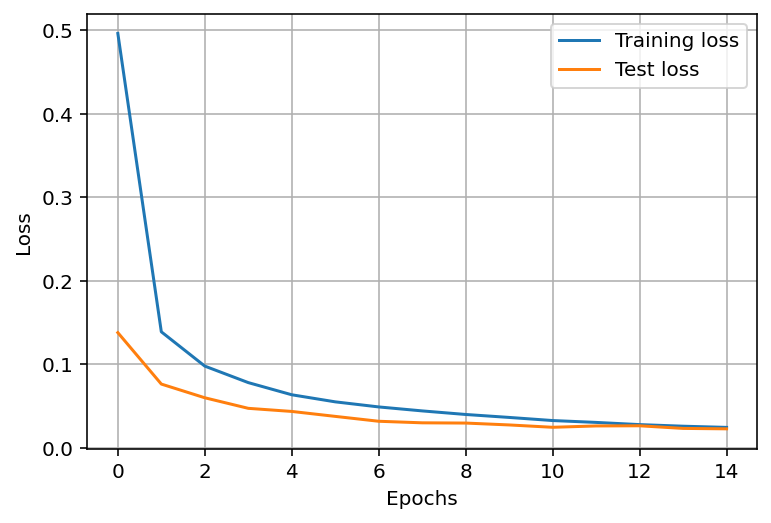

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

### Evaluating the Network

In [ ]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[1.7234619e-05 7.6676870e-06 9.9995446e-01 1.4791437e-06 5.9328130e-08
 1.2910988e-07 2.4690837e-07 1.4585071e-05 4.1908565e-06 5.3942144e-09]


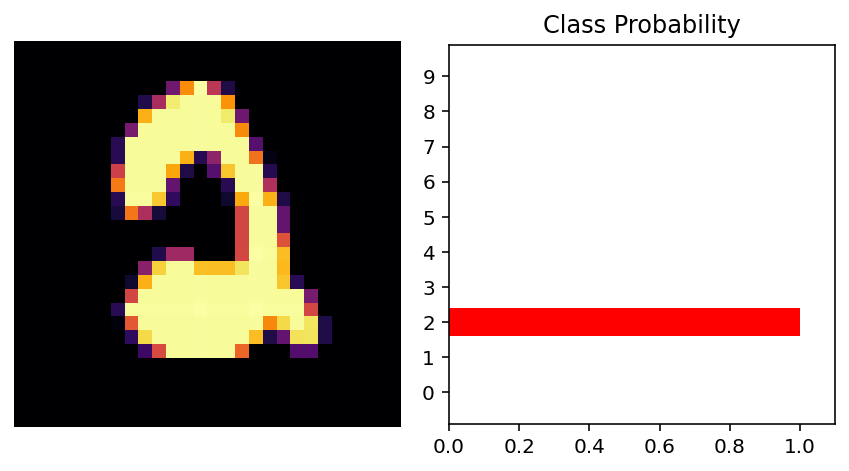

In [ ]:
# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

We can see the input image 2 matches the probability with the highest value in the probability class figure.

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # Just use cpu in this case as it is not compatible with gpu
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

The model is used to classify 20 random images from the test set.
If the digit is predicted correct then it displays the number in green. If the prediction is incorrect, then it displays the number in red.

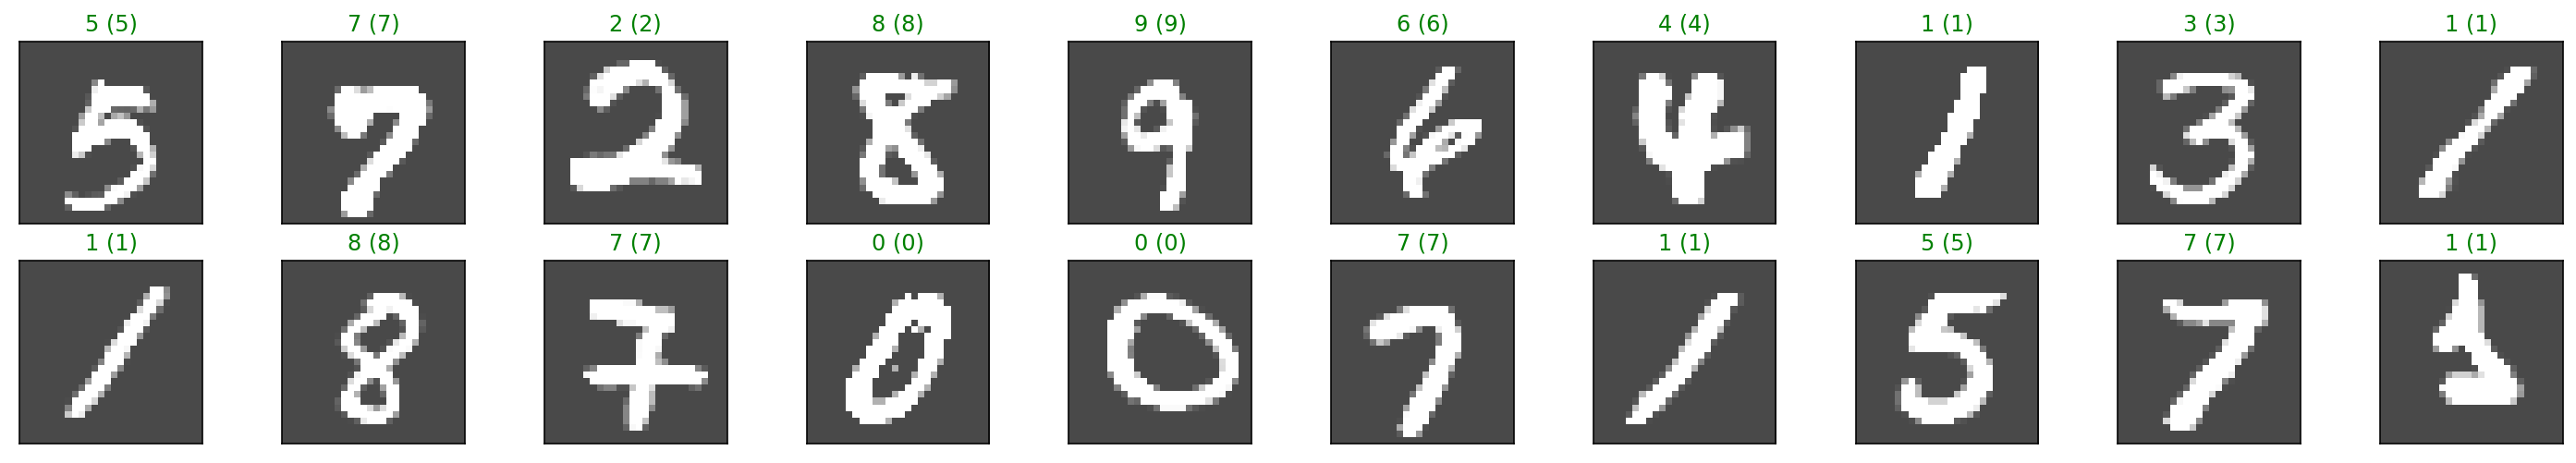

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))